<a href="https://colab.research.google.com/github/msibriani/information_retrieval_eq2/blob/main/Avance4_Equipo2_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

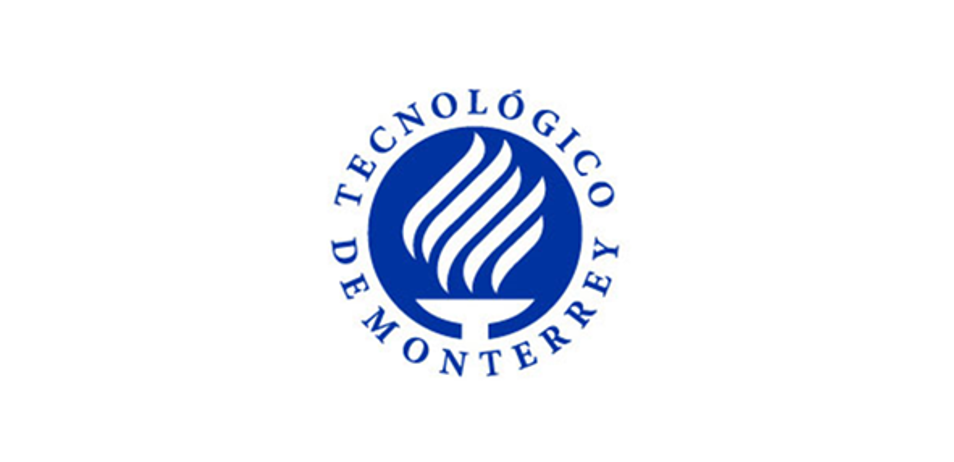

# MNA Maestría en Inteligencia Artificial Aplicada
# MNA Maestría en Inteligencia Artificial Aplicada

###Materia: TC5035.10 Proyecto Integrador
 (Gpo 10)



###Prof. Titulares:
###Dra. Grettel Barceló Alonso
###Dr. Luis Eduardo Falcón Morales



###Avance 4. Otros Modelos.



###EQUIPO 2
###Alumnos - Matrícula
###**Matthias Sibrian Illescas - A01794249**
###**José Ramiro Adán Charles - A00174646**
###**Genaro Ramos Higuera - A00351269**

###Instalamos librerias de trabajo

In [1]:
!pip install haystack-ai
!pip install "sentence-transformers>=2.2.0"
!pip install pypdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.5/319.5 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.6/320.6 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 1.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)

Cargamos librerias y definimos los metodos para cargar en memoria los documentos y la conversion de los PDFs

In [2]:
from haystack.components.writers import DocumentWriter
from haystack.components.converters import PyPDFToDocument
from haystack.components.preprocessors import DocumentSplitter, DocumentCleaner
from haystack.components.routers import FileTypeRouter
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore

document_store = InMemoryDocumentStore()
file_type_router = FileTypeRouter(mime_types=["application/pdf"])
pdf_converter = PyPDFToDocument()


Definimos el metodo para limpiar los documentos

In [3]:
document_cleaner = DocumentCleaner()
document_splitter = DocumentSplitter(split_by="word", split_length=200, split_overlap=50)


Agregamos el embedder que utilizaremos en el Pipeline para los documentos que escribiremos en la document store.

In [4]:
document_embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
document_writer = DocumentWriter(document_store)


Ahora armamos la secuencia del Pipeline a aplicar a los documentos PDF

In [5]:
preprocessing_pipeline = Pipeline()
preprocessing_pipeline.add_component(instance=file_type_router, name="file_type_router")
preprocessing_pipeline.add_component(instance=pdf_converter, name="pypdf_converter")
preprocessing_pipeline.add_component(instance=document_cleaner, name="document_cleaner")
preprocessing_pipeline.add_component(instance=document_splitter, name="document_splitter")
preprocessing_pipeline.add_component(instance=document_embedder, name="document_embedder")
preprocessing_pipeline.add_component(instance=document_writer, name="document_writer")


Ahora conectamos el Pipeline:

In [6]:
preprocessing_pipeline.connect("file_type_router.application/pdf", "pypdf_converter.sources")
preprocessing_pipeline.connect("pypdf_converter", "document_cleaner")
preprocessing_pipeline.connect("document_cleaner", "document_splitter")
preprocessing_pipeline.connect("document_splitter", "document_embedder")
preprocessing_pipeline.connect("document_embedder", "document_writer")


🚅 Components
  - file_type_router: FileTypeRouter
  - pypdf_converter: PyPDFToDocument
  - document_cleaner: DocumentCleaner
  - document_splitter: DocumentSplitter
  - document_embedder: SentenceTransformersDocumentEmbedder
  - document_writer: DocumentWriter
🛤️ Connections
  - file_type_router.application/pdf -> pypdf_converter.sources (List[Path])
  - pypdf_converter.documents -> document_cleaner.documents (List[Document])
  - document_cleaner.documents -> document_splitter.documents (List[Document])
  - document_splitter.documents -> document_embedder.documents (List[Document])
  - document_embedder.documents -> document_writer.documents (List[Document])

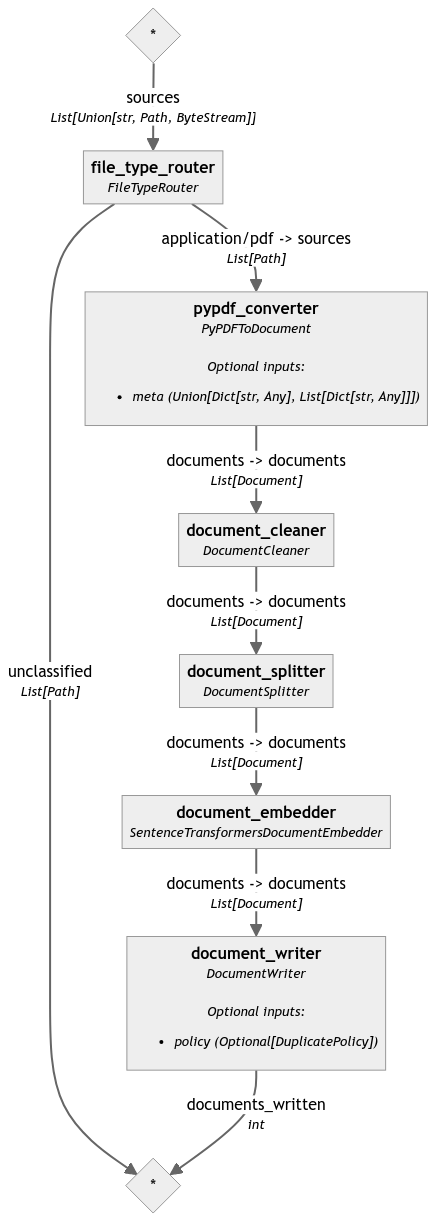

In [7]:
preprocessing_pipeline.show()

###Cargamos todos los documentos de la carpeta de PDFs /content/data/pdf
###y aplicamos el Pipeline de preprocesamiento

In [8]:
from pathlib import Path

carpeta_pdfs = "/content/data/pdf"
preprocessing_pipeline.run({"file_type_router": {"sources": list(Path(carpeta_pdfs).glob("**/*"))}})


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/149 [00:00<?, ?it/s]

{'document_writer': {'documents_written': 4756}}

Ahora utilizaremos el mismo embedder para las preguntas (questions) y poder hacer la recuperacion mediante el Retriever.

In [9]:
from haystack.components.embedders import SentenceTransformersTextEmbedder

text_embedder = SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")


In [10]:
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever

retriever = InMemoryEmbeddingRetriever(document_store)


Ahora definimos el prompt builder para las preguntas y le decimos que tome el contexto de los documentos para generar las respuestas

In [11]:
from haystack.components.builders import PromptBuilder

template = """
Given the following information, answer the question.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
"""

prompt_builder = PromptBuilder(template=template)


Ahora cargamos el API Key para el LLM que utilizaremos:

In [12]:
import os
from getpass import getpass
from haystack.components.generators import OpenAIGenerator

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")


Enter OpenAI API key:··········


In [13]:
generator = OpenAIGenerator(model="gpt-3.5-turbo")

In [14]:
basic_rag_pipeline = Pipeline()
# Adicionamos los componentes al pipeline
basic_rag_pipeline.add_component("text_embedder", text_embedder)
basic_rag_pipeline.add_component("retriever", retriever)
basic_rag_pipeline.add_component("prompt_builder", prompt_builder)
basic_rag_pipeline.add_component("llm", generator)

# Ahora los conectamos dentro del pipeline
basic_rag_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")
basic_rag_pipeline.connect("retriever", "prompt_builder.documents")
basic_rag_pipeline.connect("prompt_builder", "llm")

🚅 Components
  - text_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

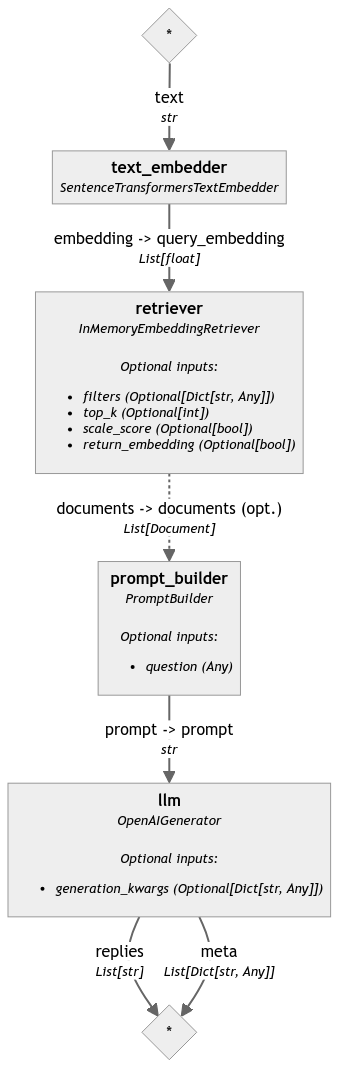

In [15]:
basic_rag_pipeline.show()

## Ahora haremos las siguientes preguntas al LLM y que se base en el contexcto de documentos

1. ¿Cuál es la definición exacta de un crédito académico en nuestra institución para los 3 niveles Preparatoria, Profesional y Posgrado?
2. ¿Cómo se determina la equivalencia de un crédito académico en términos de horas de trabajo del estudiante (lecturas, prácticas, estudio independiente, etc.)?
3. ¿Qué normativas nacionales o internacionales estamos siguiendo para la asignación de créditos académicos?
4. ¿Cuál es el proceso para evaluar y asignar créditos a un nuevo curso o programa académico?
5. ¿Cómo se aseguran los estándares de calidad y coherencia en la asignación de créditos a través de diferentes departamentos y programas?
6. ¿Cómo se calcula la carga de trabajo del estudiante para determinar el número de créditos de un curso?
7. ¿Se considera la carga de trabajo fuera del aula (como tareas y proyectos) al asignar créditos?
8. ¿De qué manera se comunica a los estudiantes la información sobre la cantidad de créditos de cada curso y la expectativa de trabajo asociada?
9. ¿Cómo se garantiza la comparabilidad de nuestros créditos académicos con los de otras instituciones a nivel nacional e internacional?
10. ¿Cuál es el proceso para la transferencia de créditos de otras instituciones y cómo se asegura su equivalencia?
11. ¿Cómo influyen los créditos académicos en el progreso y la planificación académica de los estudiantes?
12. ¿Con qué frecuencia se revisan y actualizan las políticas de créditos académicos?
13. ¿Qué criterios se utilizan para actualizar la asignación de créditos en respuesta a cambios en el contenido del curso?
14. El crédito académico representa las horas de dedicación de un alumno en un curso bajo supervisión de un profesor y actividades independientes, ¿cuál es la distribución de horas en el cálculo de un crédito?

In [16]:
question = "1. ¿Cuál es la definición exacta de un crédito académico en nuestra institución para los 3 niveles Preparatoria, Profesional y Posgrado?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La definición exacta de un crédito académico en la institución para los 3 niveles es la siguiente:

- Preparatoria: 3 créditos académicos son equivalentes a 6 unidades académicas.
- Profesional: 3 créditos académicos son equivalentes a 8 unidades académicas.
- Posgrado: 3 créditos académicos son equivalentes a 12 unidades académicas.


In [17]:
question = "2. ¿Cómo se determina la equivalencia de un crédito académico en términos de horas de trabajo del estudiante (lecturas, prácticas, estudio independiente, etc.)?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La equivalencia de un crédito académico en términos de horas de trabajo del estudiante se determina asignando 15 horas de sesiones con el profesor más 39 horas de trabajo independiente del estudiante, lo cual suma un total de 54 horas durante el periodo académico.


In [18]:
question = "3. ¿Qué normativas nacionales o internacionales estamos siguiendo para la asignación de créditos académicos?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Estamos siguiendo las normativas nacionales de la Dirección de Internacionalización del Tecnológico de Monterrey, así como las normativas internacionales relacionadas con los convenios de cooperación académica establecidos por la institución.


In [19]:
uestion = "4. ¿Cuál es el proceso para evaluar y asignar créditos a un nuevo curso o programa académico?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Para la asignación de créditos académicos, se están siguiendo las normativas nacionales e internacionales establecidas en el Reglamento para la Gestión y Operación de Programas Internacionales aplicable de acuerdo al nivel de estudios, así como las directrices de la Organización de Naciones Unidas en relación con los Objetivos de Desarrollo Sostenible.


In [20]:
question = "5. ¿Cómo se aseguran los estándares de calidad y coherencia en la asignación de créditos a través de diferentes departamentos y programas?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Se aseguran los estándares de calidad y coherencia en la asignación de créditos a través de diferentes departamentos y programas mediante la definición de políticas y procedimientos que aplican a las unidades de formación de preparatoria, profesional y posgrado en todos los formatos y campus de la institución. Además, se establecen criterios para determinar el número de créditos académicos en cada unidad de formación de manera que el total de créditos en un semestre sea consistente con los planes de estudio de profesional, maestría y doctorado. También se especifican las horas de trabajo dedicadas por los estudiantes, las semanas de impartición de unidades de formación y se definen los créditos académicos asignados a cada unidad de formación.


In [21]:
question = "6. ¿Cómo se calcula la carga de trabajo del estudiante para determinar el número de créditos de un curso?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La carga de trabajo del estudiante para determinar el número de créditos de un curso se calcula considerando el tiempo de trabajo que el alumno dedica a la unidad de formación para cumplir con los objetivos del mismo. Los créditos académicos representan tanto la asistencia a las horas de clase como el tiempo dedicado al trabajo independiente del alumno. Además, para programas de salud con actividades clínicas, la carga académica se mide por el tiempo total que la unidad de formación demande a los alumnos durante una semana.


In [22]:
question = "7. ¿Se considera la carga de trabajo fuera del aula (como tareas y proyectos) al asignar créditos?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Sí, se considera la carga de trabajo fuera del aula (como tareas y proyectos) al asignar créditos. Los créditos académicos representan tanto la asistencia a las horas-clase como el tiempo dedicado al trabajo independiente del alumno.


In [23]:
question = "8. ¿De qué manera se comunica a los estudiantes la información sobre la cantidad de créditos de cada curso y la expectativa de trabajo asociada?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La información sobre la cantidad de créditos de cada curso y la expectativa de trabajo asociada se comunica a los estudiantes a través de la definición de un crédito académico, la cual indica que cada crédito corresponde a 15 horas de sesiones con el profesor más 39 horas de trabajo independiente del estudiante, para un total de 54 horas durante el periodo académico. Además, se establece que cada unidad de formación tiene asignados 2 créditos. También se menciona que la carga académica de tiempo completo por periodo regular es de 8 créditos, con la posibilidad de hasta 2 créditos de sobrecarga, y de 4 créditos para periodo intensivo sin sobrecarga. Esta información se encuentra detallada en los documentos de Políticas y Normas Académicas Generales.


In [24]:
question = "9. ¿Cómo se garantiza la comparabilidad de nuestros créditos académicos con los de otras instituciones a nivel nacional e internacional?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Se garantiza la comparabilidad de los créditos académicos con otras instituciones a nivel nacional e internacional a través de la traducción de la escala de calificaciones a su equivalente con el Sistema Tecnológico de Monterrey, la cual debe estar incluida en todos los convenios con universidades extranjeras. Además, se establecen criterios de calificación y carga académica claros para los alumnos que participen en programas internacionales, y se asegura que los programas se rijan por los criterios del reglamento académico correspondiente.


In [25]:
question = "10. Cuál es el proceso para la transferencia de créditos de otras instituciones y cómo se asegura su equivalencia?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

El proceso para la transferencia de créditos de otras instituciones en el Tecnológico de Monterrey se basa en la equivalencia de horas-crédito por semestre. Se estiman las horas de trabajo correspondientes a los cursos en horas-crédito por semestre de acuerdo con diferentes criterios, como una hora de clase por semana de un curso semestral corresponde a una hora-crédito por semestre. Además, se establecen directrices específicas para programas de posgrado, especialidades, maestrías, y doctorados, asegurando que las unidades de formación de otros programas sean equivalentes a las del Tecnológico de Monterrey. Se consideran criterios como la carga académica total, el tiempo de trabajo dedicado por los alumnos, y la distribución de créditos entre diferentes tipos de unidades de formación. Todo esto se realiza para garantizar la equivalencia y validez de los créditos transferidos de otras instituciones.


In [26]:
question = "11. ¿Cómo influyen los créditos académicos en el progreso y la planificación académica de los estudiantes?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Los créditos académicos influyen en el progreso y la planificación académica de los estudiantes al determinar la carga de trabajo y el tiempo dedicado a cada materia o unidad de formación. Los créditos asignados a cada curso o programa indican la cantidad de horas de trabajo requeridas para completarlo con éxito, lo que ayuda a los estudiantes a organizar su tiempo y esfuerzo de manera efectiva. Además, los créditos académicos también son utilizados para evaluar el progreso de los estudiantes hacia la obtención de su título o certificación académica, ya que su acumulación es necesaria para cumplir con los requisitos de graduación. Por lo tanto, los créditos académicos son un factor clave en la planificación de los estudios y en la medición del avance académico de los estudiantes.


In [27]:
question = "12. ¿Con qué frecuencia se revisan y actualizan las políticas de créditos académicos?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Las políticas de créditos académicos se revisan y actualizan con frecuencia, ya que se menciona en el contexto que se incluirán en las Políticas y Normas Académicas Generales en su próxima edición, lo que sugiere que se realiza una revisión periódica y actualización de estas normativas.


In [28]:
question = "13. ¿Qué criterios se utilizan para actualizar la asignación de créditos en respuesta a cambios en el contenido del curso?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Se utilizan criterios como la definición de un crédito académico, las horas de sesiones con el profesor, las horas de trabajo independiente del estudiante, y las unidades de formación de los programas en línea.


In [29]:
question = "14. El crédito académico representa las horas de dedicación de un alumno en un curso bajo supervisión de un profesor y actividades independientes, ¿cuál es la distribución de horas en el cálculo de un crédito?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Según la información proporcionada, la distribución de horas en el cálculo de un crédito académico es la siguiente: 15 horas de sesiones con el profesor más 39 horas de trabajo independiente del estudiante, lo cual suma un total de 54 horas durante el periodo académico.


## Ahora probamos con el LLM Mistral mistralai/Mixtral-8x7B-Instruct-v0.1

In [30]:
from haystack.components.generators import HuggingFaceAPIGenerator

if "HF_API_TOKEN" not in os.environ:
    os.environ["HF_API_TOKEN"] = getpass("Enter Hugging Face token:")

Enter Hugging Face token:··········


In [31]:

generator =HuggingFaceAPIGenerator(api_type="serverless_inference_api", api_params={"model": "mistralai/Mixtral-8x7B-Instruct-v0.1"})

In [32]:
question = "1. ¿Cuál es la definición exacta de un crédito académico en nuestra institución para los 3 niveles Preparatoria, Profesional y Posgrado?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Un crédito académico en nuestra institución equivale a 3 unidades académicas en Preparatoria, 3 unidades académicas en Profesional y 12 unidades académicas en Posgrado (planes versión anterior a 2024).


In [33]:
question = "2. ¿Cómo se determina la equivalencia de un crédito académico en términos de horas de trabajo del estudiante (lecturas, prácticas, estudio independiente, etc.)?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La equivalencia de un crédito académico en términos de horas de trabajo del estudiante se determina considerando que un crédito académico requiere 120 horas de trabajo del estudiante, incluyendo horas clase y horas de trabajo independiente.


In [34]:
question = "3. ¿Qué normativas nacionales o internacionales estamos siguiendo para la asignación de créditos académicos?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Estamos siguiendo las normativas nacionales o internacionales establecidas por la Dirección de Internacionalización y publicadas en el Reglamento para la Gestión y Operación de Programas Internacionales, aplicable de acuerdo al nivel de estudios.


In [35]:
uestion = "4. ¿Cuál es el proceso para evaluar y asignar créditos a un nuevo curso o programa académico?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Estamos siguiendo normativas nacionales e internacionales para la asignación de créditos académicos, como se menciona en el Reglamento para la Gestión y Operación de Programas Internacionales aplicable de acuerdo al nivel de estudios, establecido por la Dirección de Internacionalización del Tecnológico de Monterrey.


In [36]:
question = "5. ¿Cómo se aseguran los estándares de calidad y coherencia en la asignación de créditos a través de diferentes departamentos y programas?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Los estándares de calidad y coherencia en la asignación de créditos se aseguran a través de políticas y procedimientos establecidos que aplican en todas las unidades de formación de preparatoria, profesional y posgrado, en todos los formatos de programas ofrecidos (en línea o presenciales) y en todos los campus. Además, la carga académica de cada unidad de formación y el tiempo de trabajo dedicado por los estudiantes se define de acuerdo con criterios específicos, como el número de semanas de impartición, horas de clase por semana, y horas de trabajo independiente. También se establecen requisitos mínimos de créditos para cada nivel de estudio (especialidades, maestrías, doctorados) y se definen los créditos académicos asignados a cada unidad de formación. La Dirección de Posgrados y la Vicerrectoría de Innovación Educativa y Normatividad Académica son responsables de autorizar y oficializar los programas de posgrado, asegurando que cumplan con los estándares establecidos.


In [37]:
question = "6. ¿Cómo se calcula la carga de trabajo del estudiante para determinar el número de créditos de un curso?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La carga de trabajo del estudiante para determinar el número de créditos de un curso se calcula basándose en el tiempo dedicado a la unidad de formación para cumplir con los objetivos del curso. Los créditos académicos representan tanto la asistencia a las horas-clase como el tiempo dedicado al trabajo independiente del alumno. Para programas de salud con actividades clínicas, la carga académica se mide por el tiempo total que la unidad de formación demande a los alumnos durante una semana.


In [38]:
question = "7. ¿Se considera la carga de trabajo fuera del aula (como tareas y proyectos) al asignar créditos?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Sí, se considera la carga de trabajo fuera del aula al asignar créditos. Los créditos académicos representan tanto la asistencia a las horas-clase como el tiempo dedicado al trabajo independiente del alumno, lo cual incluye tareas y proyectos.


In [39]:
question = "8. ¿De qué manera se comunica a los estudiantes la información sobre la cantidad de créditos de cada curso y la expectativa de trabajo asociada?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La información sobre la cantidad de créditos de cada curso y la expectativa de trabajo asociada se comunica a los estudiantes a través del número de créditos asignados a cada unidad de formación, así como la definición de un crédito académico que incluye 15 horas de sesiones con el profesor más 39 horas de trabajo independiente del estudiante, lo cual suma un total de 54 horas por cada crédito durante el periodo académico. Además, se establecen diferentes cargas académicas para estudiantes de tiempo completo en periodos regulares y intensivos, especificando la cantidad de créditos que deben llevar en cada caso.


In [40]:
question = "9. ¿Cómo se garantiza la comparabilidad de nuestros créditos académicos con los de otras instituciones a nivel nacional e internacional?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Se garantiza la comparabilidad de los créditos académicos con otras instituciones a nivel nacional e internacional mediante la inclusión de la traducción de la escala de calificaciones de las universidades extranjeras a su equivalente en el Sistema Tecnológico de Monterrey en todos los convenios. Además, se establece que la asignación de calificaciones se hará de acuerdo con criterios específicos establecidos en los convenios correspondientes, asegurando así la equivalencia y la transparencia en la transferencia de créditos académicos.


In [41]:
question = "10. Cuál es el proceso para la transferencia de créditos de otras instituciones y cómo se asegura su equivalencia?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

El proceso para la transferencia de créditos de otras instituciones implica que el alumno solicite la equivalencia de sus créditos a través de los procedimientos establecidos por la institución a la que desea transferirse. El objetivo es asegurar que los créditos cursados en otra institución sean reconocidos como equivalentes a los cursos ofrecidos en el Tecnológico de Monterrey. Para asegurar su equivalencia, se pueden utilizar criterios como la comparación de la carga académica y la duración de los cursos, así como la revisión de los contenidos y resultados de aprendizaje. Además, es importante que el alumno presente la documentación requerida, como certificados de cursos y programas de estudio, para facilitar el proceso de evaluación y reconocimiento de los créditos transferidos.


In [42]:
question = "11. ¿Cómo influyen los créditos académicos en el progreso y la planificación académica de los estudiantes?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Los créditos académicos influyen en el progreso y la planificación académica de los estudiantes al determinar la carga de trabajo y el tiempo dedicado a cada materia o unidad de formación. Los créditos asignados a cada curso o programa académico permiten a los estudiantes tener una idea clara de cuánto esfuerzo y tiempo deberán dedicar a cada asignatura para completar satisfactoriamente su plan de estudios. Además, los créditos académicos también son utilizados para medir el avance curricular, la carga académica necesaria para ser considerado estudiante a tiempo completo, y la posible transferencia de créditos entre diferentes programas educativos o instituciones. En resumen, los créditos académicos son un elemento fundamental en la organización y seguimiento de la trayectoria académica de los estudiantes.


In [43]:
question = "12. ¿Con qué frecuencia se revisan y actualizan las políticas de créditos académicos?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Las políticas de créditos académicos se revisan y actualizan periódicamente, ya que en el texto se mencionan cambios y actualizaciones en los reglamentos académicos que aplican a partir de una fecha específica. No se especifica una frecuencia exacta, pero se sugiere que se realizan revisiones y actualizaciones de forma regular para adaptarse a las necesidades y normativas vigentes.


In [44]:
question = "13. ¿Qué criterios se utilizan para actualizar la asignación de créditos en respuesta a cambios en el contenido del curso?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Se utilizan criterios como el número de horas de sesiones con el profesor, horas de trabajo independiente del estudiante, y la carga académica de tiempo completo del estudiante por periodo regular.


In [45]:
question = "14. El crédito académico representa las horas de dedicación de un alumno en un curso bajo supervisión de un profesor y actividades independientes, ¿cuál es la distribución de horas en el cálculo de un crédito?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

En el cálculo de un crédito académico, se consideran 15 horas de sesiones con el profesor más 39 horas de trabajo independiente del estudiante, lo cual suman un total de 54 horas durante el periodo académico.


## Ahora probamos con el LLM Cohere "CohereForAI/aya-23-8B"

In [46]:
generator =HuggingFaceAPIGenerator(api_type="serverless_inference_api", api_params={"model": "CohereForAI/aya-23-8B"})

In [47]:
question = "1. ¿Cuál es la definición exacta de un crédito académico en nuestra institución para los 3 niveles Preparatoria, Profesional y Posgrado?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La definición exacta de un crédito académico en la institución para los 3 niveles es la siguiente:

- Preparatoria: 3 créditos académicos son equivalentes a 6 unidades académicas.
- Profesional: 3 créditos académicos son equivalentes a 8 unidades académicas.
- Posgrado: 3 créditos académicos son equivalentes a 12 unidades académicas.


In [48]:
question = "2. ¿Cómo se determina la equivalencia de un crédito académico en términos de horas de trabajo del estudiante (lecturas, prácticas, estudio independiente, etc.)?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La equivalencia de un crédito académico en términos de horas de trabajo del estudiante se determina en base a 15 horas de sesiones con el profesor más 39 horas de trabajo independiente del estudiante, lo cual suma un total de 54 horas durante el periodo académico.


In [49]:
question = "3. ¿Qué normativas nacionales o internacionales estamos siguiendo para la asignación de créditos académicos?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Estamos siguiendo normativas nacionales e internacionales establecidas por la Dirección de Internacionalización y la Vicerrectoría Asociada de Internacionalización para la asignación de créditos académicos en programas internacionales.


In [50]:
uestion = "4. ¿Cuál es el proceso para evaluar y asignar créditos a un nuevo curso o programa académico?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Estamos siguiendo las normativas nacionales o internacionales establecidas por la Dirección de Internacionalización y publicadas en el Reglamento para la Gestión y Operación de Programas Internacionales aplicable de acuerdo al nivel de estudios.


In [51]:
question = "5. ¿Cómo se aseguran los estándares de calidad y coherencia en la asignación de créditos a través de diferentes departamentos y programas?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Los estándares de calidad y coherencia en la asignación de créditos a través de diferentes departamentos y programas se aseguran mediante la definición de normativas y procedimientos establecidos para cada nivel de estudio, ya sea preparatoria, profesional o posgrado. Estos incluyen la determinación de créditos académicos por unidad de formación, la carga académica por periodo regular e intensivo, y la asignación de créditos según la duración y dedicación requerida por cada programa. Además, se establecen criterios de equivalencia para la reprobación de unidades de formación y se definen requisitos específicos para la conservación de becas y apoyos financieros. Todo esto se rige bajo políticas y procedimientos institucionales que son responsabilidad de las Escuelas y departamentos académicos, garantizando la coherencia y calidad en la asignación de créditos a lo largo de los diferentes programas y departamentos.


In [52]:
question = "6. ¿Cómo se calcula la carga de trabajo del estudiante para determinar el número de créditos de un curso?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La carga de trabajo del estudiante para determinar el número de créditos de un curso se calcula en base al tiempo de trabajo que el alumno dedica a la unidad de formación para cumplir con los objetivos del mismo. Los créditos académicos representan tanto la asistencia a las horas-clase como el tiempo dedicado al trabajo independiente del alumno, y varían dependiendo de la cantidad de horas totales que la unidad de formación demande a los alumnos durante una semana.


In [53]:
question = "7. ¿Se considera la carga de trabajo fuera del aula (como tareas y proyectos) al asignar créditos?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Sí, se considera la carga de trabajo fuera del aula, como tareas y proyectos, al asignar créditos. Los créditos académicos representan tanto la asistencia a las horas-clase como el tiempo dedicado al trabajo independiente del alumno.


In [54]:
question = "8. ¿De qué manera se comunica a los estudiantes la información sobre la cantidad de créditos de cada curso y la expectativa de trabajo asociada?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La información sobre la cantidad de créditos de cada curso y la expectativa de trabajo asociada se comunica a los estudiantes a través de la definición de un crédito académico que incluye 15 horas de sesiones con el profesor más 39 horas de trabajo independiente del estudiante, lo cual suma un total de 54 horas durante el periodo académico. Además, se menciona que cada unidad de formación tiene asignados 2 créditos y se establecen estándares de dedicación por crédito para los cursos intensivos. También se especifica que la carga académica de tiempo completo para un estudiante es de 8 créditos por periodo regular y 4 créditos por periodo intensivo. Todo esto se detalla en el documento que contiene las Políticas y Normas Académicas Generales de la institución.


In [55]:
question = "9. ¿Cómo se garantiza la comparabilidad de nuestros créditos académicos con los de otras instituciones a nivel nacional e internacional?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Se garantiza la comparabilidad de nuestros créditos académicos con los de otras instituciones a nivel nacional e internacional a través de la traducción de la escala de calificaciones de las universidades extranjeras a su equivalente con el Sistema Tecnológico de Monterrey. Además, se establecen criterios de calificación y carga académica en los convenios de programas internacionales para informar a los alumnos antes de su partida. También se verifica que el grado académico sea oficial y esté registrado en el Ministerio de Educación del país correspondiente, así como se busca la equivalencia del grado con el sistema educativo mexicano y se verifican certificaciones académicas reconocidas a nivel internacional. 


In [56]:
question = "10. Cuál es el proceso para la transferencia de créditos de otras instituciones y cómo se asegura su equivalencia?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

El proceso para la transferencia de créditos de otras instituciones en el Tecnológico de Monterrey se realiza a través de la Oficina de Registros Académicos. Para asegurar la equivalencia de los créditos, se realiza una evaluación detallada de los programas y cursos de las instituciones de origen con los del Tecnológico de Monterrey. Además, se comparan las horas de trabajo, los objetivos de los cursos y las competencias adquiridas para determinar si los créditos pueden ser transferidos de manera adecuada. Este proceso garantiza que los estudiantes reciban el reconocimiento apropiado por los estudios realizados en otras instituciones.


In [57]:
question = "11. ¿Cómo influyen los créditos académicos en el progreso y la planificación académica de los estudiantes?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Los créditos académicos determinan la cantidad de trabajo que un estudiante debe completar en una materia o unidad de formación. Esto influye en el progreso académico de los estudiantes, ya que les permite planificar de manera efectiva cuántas materias pueden cursar en un semestre, cuánto tiempo dedicar a cada una y en qué momento avanzar en su plan de estudios. Además, los créditos académicos son una medida estándar que facilita la comparación entre distintos programas educativos y niveles de estudios, lo que ayuda a los estudiantes a tomar decisiones informadas sobre su trayectoria académica.


In [58]:
question = "12. ¿Con qué frecuencia se revisan y actualizan las políticas de créditos académicos?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Las políticas de créditos académicos se revisan y actualizan de manera periódica, ya que se menciona que se aplican a partir de una fecha específica y se incluirán en las Políticas y Normas Académicas Generales en la próxima edición.


In [59]:
question = "13. ¿Qué criterios se utilizan para actualizar la asignación de créditos en respuesta a cambios en el contenido del curso?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Se utilizan criterios como la carga académica de tiempo completo, la definición de crédito académico y la estructura de programas de posgrado.


In [60]:
question = "14. El crédito académico representa las horas de dedicación de un alumno en un curso bajo supervisión de un profesor y actividades independientes, ¿cuál es la distribución de horas en el cálculo de un crédito?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Según la información proporcionada, la distribución de horas en el cálculo de un crédito académico es la siguiente:

- 15 horas de sesiones con el profesor
- 39 horas de trabajo independiente del estudiante

Esto da un total de 54 horas en total durante el periodo académico.
